In [1]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
# regression analysis
from linearmodels import IV2SLS 

import sys
import os
from pathlib import Path

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")

from players_season_builder import *
from modeling import *

In [4]:
player_path = r"\Users\sebas\Desktop\UChicago - Q6\Sports Analytics\sports_analytics_project\data\BDB_Player.xlsx"
df_player = pd.read_excel(player_path)

df_player.columns = ['DATASET', 'DATE', 'PLAYER FULL NAME', 'POSITION', 'OWN TEAM',
       'OPP TEAM', 'VENUE', 'MIN', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'OR',
       'DR', 'TOT', 'A', 'PF', 'ST', 'TO', 'BL', 'PTS', 'PER', 'DATE-DIFF',
       'RR VAL', 'RR SERIES', 'S_PER', 'I_PER', 'SAME_CITY', 'TRAVEL',
       '1_days', '10_days', '11_days', '12_days', '13_days',
       '14+_days', '14_days', '2_days', '3_days', '4_days', '5_days',
       '6_days', '7_days', '8_days', '9_days', 'Season_Start',
       'H', 'R', 'H-M1', 'H-M2', 'H-M3', 'R-M1', 'R-M2', 'R-M3', 'M1', 'M2',
       'M3', 'S_OEFF', 'S_DEFF', 'I_OEFF', 'I_DEFF','Bubble']

Filter out B2B

In [91]:
sample_df = df_player[df_player['1_days'] == 1][['PLAYER FULL NAME','DATASET','PER','MIN','DATE']]
sample_df['PREV_DATE'] = df_player.DATE - pd.Timedelta(days=1)
sample_df.set_index(['DATASET','PLAYER FULL NAME'])
test_df = df_player[['PLAYER FULL NAME','DATASET','DATE','PER','MIN']]
test_df.set_index(['DATASET','PLAYER FULL NAME'])
sample_df = sample_df.merge(test_df, left_on=['DATASET','PLAYER FULL NAME','PREV_DATE'], right_on=['DATASET','PLAYER FULL NAME','DATE'], suffixes=('','_prev'))

sample_df['played_before?'] = np.where(sample_df['MIN_prev'] == 0, 0 , 1 )
sample_df['>30'] = np.where(sample_df['MIN_prev'] >= 30, 1 , 0 )
sample_df['MIN_diff'] = sample_df['MIN_prev'] - sample_df['MIN']
sample_df['PER_DIFF'] = sample_df['PER_prev'] - sample_df['PER']
sample_df['played_less_before'] = np.where(sample_df['MIN_prev'] < sample_df['MIN'], True , False )

<AxesSubplot:>

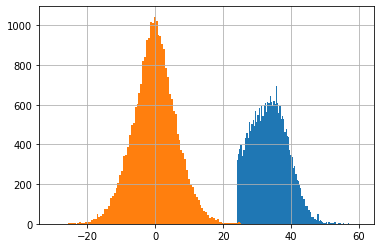

In [77]:
sample_df['MIN_prev'].hist(bins=100)
sample_df['MIN_diff'].hist(bins=100)


(0.0, 40.0)

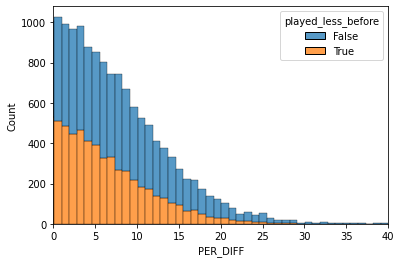

In [92]:
fig, ax = plt.subplots()
sns.histplot(data = sample_df, x = 'PER_DIFF', hue = 'played_less_before', bins=100, ax=ax, multiple = "stack" )
ax.set_xlim([0,40])

In [103]:
sample_df.groupby(['played_less_before']).agg( {
    'PER_DIFF' : [np.count_nonzero, np.max, np.average, np.std],
    'MIN' : [np.average, np.std],
    'MIN_prev' : [np.average, np.std]
}
)

PER_DIFF                               MIN             \
                   count_nonzero   average       std count_nonzero    average   
played_less_before                                                              
False                      12633  2.758642  9.323434         12633  31.278530   
True                       13281 -2.370193  9.352980         13281  36.278783   

                                  MIN_prev                       
                         std count_nonzero    average       std  
played_less_before                                               
False               4.532435         12633  36.169393  4.941741  
True                4.994646         13281  31.287176  4.577980

In [104]:

sample_df.groupby(['>30']).agg( {
    'PER_DIFF' : [np.count_nonzero, np.average, np.std],
    'MIN' : [np.count_nonzero, np.average, np.std],
    'MIN_prev' : [np.count_nonzero,np.average, np.std]
}
)

PER_DIFF                               MIN                       \
    count_nonzero   average       std count_nonzero    average       std   
>30                                                                        
0            7244 -2.230632  8.834994          7244  31.905817  4.975884   
1           18670  1.046068  9.842818         18670  34.592097  5.356598   

         MIN_prev                       
    count_nonzero    average       std  
>30                                     
0            7244  27.256334  1.711988  
1           18670  36.154689  4.052894